# Attitude determination

## august campaign

### load data from logs

In [2]:
indir="/home/limu/Lab/Alpha/station/processed_jr/"
date='2021-08-10'
import os
import pandas as pd
#aug1=pd.read_csv(indir+date+'/hk_data_decoded.txt',delimiter='\t')
aug1=pd.read_csv("/home/limu/Space/logs/alpha/hk_data_august_last.txt",delimiter='\t')
aug1.columns

Index(['RealTimeStamp', 'DK EpochTimeStamp [s]', 'DK TimeStamp', 'CunkID',
       'ChunkType', 'Length [B]', 'LdSt magX [nT]', 'LdSt magY [nT]',
       'LdSt magZ [nT]', 'LdStTot [nT]', 'OBC magX [nT]', 'OBC magY [nT]',
       'OBC magZ [nT]', 'OBCtot [nT]', 'OBC_9DOF_Temp [*C]',
       'OBCgyroX [deg/s]', 'OBCgyroY [deg/s]', 'OBCgyroZ [deg/s]',
       'OBCaccX [mG]', 'OBCaccY [mG]', 'OBCaccZ [mG]', 'SolT X+ [*C]',
       'SolT Y+ [*C]', 'SolT X- [*C]', 'SolT Y- [*C]', 'SolT Z- [*C]',
       'OBC_Temp [*C]', 'ssTemp(X+) [*C]', 'ssTemp(Y+) [*C]',
       'ssTemp(X-) [*C]', 'ssTemp(Y-) [*C]', 'ssTemp(Z-) [*C]', 'ssIRRad(X+)',
       'ssIRRad(Y+)', 'ssIRRad(X-)', 'ssIRRad(Y-)', 'ssIRRad(Z-)',
       'ssAngleX (X+) [deg]', 'ssAngleY (X+) [deg]', 'ssAngleX (Y+) [deg]',
       'ssAngleY (Y+) [deg]', 'ssAngleX (X-) [deg]', 'ssAngleY (X-) [deg]',
       'ssAngleX (Y-) [deg]', 'ssAngleY (Y-) [deg]', 'ssAngleX (Z-) [deg]',
       'ssAngleY (Z-) [deg]', 'ssGyroX (X+) [deg/s]', 'ssGyroY (X+) [deg/s

In [4]:
mok=aug1
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
from datetime import datetime,timedelta
mags=np.array([np.array(mok[mok.columns[6+i]]) for i in range(3)]).T
mags=mags[1:-1]

In [104]:
irpos=[i for i in range(len(mok.columns)) if mok.columns[i].find("IRR")>0]
rep=[]
qth = (48.7408,-21.2284,380)
from astropy import coordinates as coord
from astropy import units as u
import predict
tle= """GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965"""
pars=['longitude','latitude','altitude','epoch']
kosice=coord.EarthLocation.from_geodetic(qth[1],-qth[0],qth[2])#,unit=(u.degree, u.degree,u.meter))
kosrad=np.sqrt(sum(np.array(kosice.value.tolist())**2))*1e-3 #earth distance in km

for d in mok['DK TimeStamp']:
    x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
    y=predict.observe(tle, qth, at=x.timestamp())
    rep.append([y['longitude'],y['latitude'],y['altitude']])
rep=np.array(rep).T
if rep[0].max()-rep[0].min()>200:rep[0]=(rep[0]+180)%360-180

In [105]:
from periodogram import get_mag_dir

pomag=[]
for i in [0,len(rep)-1]:
    day=mok['DK TimeStamp'][i].split(' ')[0]
    day='-'.join(day.split('-')[::-1])
    pomag.append(get_mag_dir(day,rep[0][i],rep[1][i],rep[2][i]))
    
pom1,pom2=pomag[0],pomag[-1]
vecs=[np.array([dic[t+'-intensity'] for t in ['east','north','vertical']]) for dic in pomag]#'declination'] 
norm=lambda v:np.sqrt(np.dot(v,v))
nvecs=[v/norm(v) for v in vecs]
nvecs

[array([-0.089067  ,  0.26239306,  0.96084179]),
 array([-0.08945222,  0.26472176,  0.96016701])]

In [106]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in rep.T] 
times=[datetime.strptime(m,"%d-%m-%Y %H:%M:%S") for m in mok['DK TimeStamp']]


In [107]:
from imp import reload
import periodogram as pg
reload(periodogram)

<module 'periodogram' from '/home/limu/Code/Notebook/Astro/cube/periodogram.py'>

In [108]:
sunvec_hall=np.array([pg.sun_vec_CHall(t) for t in times])
#some "eye" estimate
irvec=np.array([[0,-0.9,np.sqrt(0.19)],[-0.9/np.sqrt(2),-0.9/np.sqrt(2),np.sqrt(0.19)],[-0.8,-np.sqrt(0.17),np.sqrt(0.19)],])

In [109]:
all_rot=[]
from satutils import triad
dt=np.array([(t-times[0]).seconds for t in times])
dtot=dt[-1]
magdir=[coord.SkyCoord(pomag[i]['inclination'],pomag[i]['declination'],unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]
magvec=[np.array([c.x.value,c.y.value,c.z.value]) for c in [m.fk5.cartesian for m in magdir]]
magvec=[m/norm(m) for m in magvec]
mag_inter = lambda t:(t/dtot*magvec[1]+(1-t/dtot)*magvec[0])

for i in [0,1,2]:
    t_body=triad(mags[i]/norm(mags[i]),irvec[i]) #body frame
    t_equa=triad(mag_inter(dt[i]),sunvec_hall[i]) #ra dec frame
    #rot_body_equa=t_equa.T@t_body
    all_rot.append(t_equa.T@t_body)


In [110]:
## prediction of Sun direction in body frame?

[all_rot[i].T@sunvec_hall[i] for i in range(3)]

[array([ 0.53343735, -0.73507031, -0.41846891]),
 array([-0.86086797, -0.06243918, -0.50498179]),
 array([-0.8908003 ,  0.35190352, -0.2874665 ])]

### finding proper sun direction

- fix the magnetic field direction
- est. angle between sun and magnet
- vary "azimuth" of sun vector to fit best the observation

In [46]:
angle=[np.arccos(np.dot(mag_inter(dt[i]),sunvec_hall[i])) for i in range(len(dt))]
#pl.plot(np.rad2deg(angle))
angle=np.mean(angle) #changes negligeable

In [50]:
#pl.plot(np.rad2deg(angle))
angle=np.mean(angle) #changes negligeable

In [97]:
mbody=[m/norm(m) for m in mags]
phi=np.r_[:2*np.pi:40j]
j=3
wee=np.array([np.cos(angle),np.sin(angle)*np.cos(phi[j]),np.sin(angle)*np.sin(phi[j])])

In [98]:
rmatx=triad(mbody[j],[0,0,1])
sun_ex=rmatx.T@wee
np.arccos(np.dot(sun_ex,mbody[j]))

1.6133322232921679

[[<matplotlib.lines.Line2D at 0x7f8fa7bcb310>],

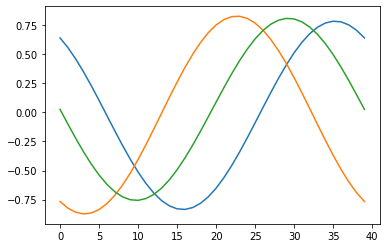

In [99]:
#np.allclose(rmatx.T@rmatx,np.eye(3)) # rmatx is orthonormal
awee=np.array([np.cos(angle)*np.ones_like(phi),np.sin(angle)*np.cos(phi),np.sin(angle)*np.sin(phi)])
asun=rmatx.T@awee # in body frame
[pl.plot(s) for s in asun]

### try some model

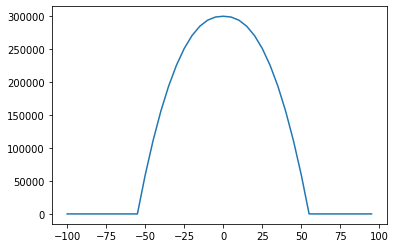

In [51]:
amp=3e5
mang=55
zex=2.3
viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*amp
angs=np.r_[-100:100:5]
pl.plot(angs,[viewang(a) for a in angs])

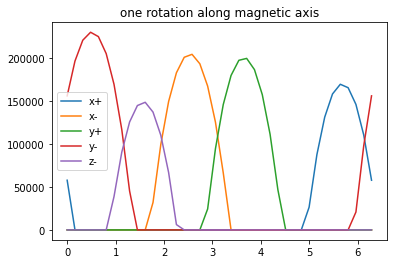

In [103]:
xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

In [111]:
tle_all=open("/home/limu/Code/Notebook/Astro/alpha/ephem/tle_all.txt").readlines()
tle_arr=[tle_all[4*i+1].replace('-','.').replace('+','.').split()[3:]+tle_all[4*i+2].replace('-','.').split()[2:] for i in range(len(tle_all)//4)]

In [140]:
tle_grb=''.join([t[30:] for t in tle_all[-3:]])
tle_pre=''.join([t[30:] for t in tle_all[-7:-4]])

print(tle_pre)
print(tle_grb)

GRBALPHA                
1 47959U 21022AD  22047.50776378  .00003147  00000+0  21647-3 0  9996
2 47959  97.5424 309.6188 0020571 194.7841 268.3098 15.06467169 48600

GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965



In [141]:
tle_grb=''.join([t[30:] for t in tle_all[-3:]])
tle_grb='''GRBALPHA
1 47959U 21022AD  22089.06574127  .00004075  00000-0  27671-3 0  9996
2 47959  97.5376 350.3030 0022746  59.5456 300.8062 15.06733026 54867'''
now=datetime.now()
trans=predict.transits(tle_grb,qth,now.timestamp(),(now+timedelta(0,1e6)).timestamp())
trans=[t for t in trans if t.peak()['elevation']>10]

In [163]:
from datetime import timezone#.utc as utc
timezone.utc
#now.tzinfo
#timezone.timezone('Europe/Prague')
t=trans[2]
datetime.fromtimestamp(t.start,timezone.utc)#.tzinfo

datetime.datetime(2022, 3, 31, 21, 5, 54, 581940, tzinfo=datetime.timezone.utc)

In [158]:
t.

datetime.timezone.utc

In [164]:
[[datetime.fromtimestamp(tx,timezone.utc).isoformat()[:19].replace('T',' ') for tx in [t.start,t.peak()['epoch'],t.end]] for t in trans]

[['2022-03-31 07:59:41', '2022-03-31 08:05:17', '2022-03-31 08:10:55'],
 ['2022-03-31 09:34:18', '2022-03-31 09:39:55', '2022-03-31 09:45:36'],
 ['2022-03-31 21:05:54', '2022-03-31 21:11:37', '2022-03-31 21:17:21'],
 ['2022-03-31 22:40:35', '2022-03-31 22:46:17', '2022-03-31 22:52:01'],
 ['2022-04-01 07:54:18', '2022-04-01 07:59:49', '2022-04-01 08:05:23'],
 ['2022-04-01 09:28:42', '2022-04-01 09:34:24', '2022-04-01 09:40:13'],
 ['2022-04-01 21:00:27', '2022-04-01 21:06:06', '2022-04-01 21:11:44'],
 ['2022-04-01 22:35:03', '2022-04-01 22:40:49', '2022-04-01 22:46:35'],
 ['2022-04-02 07:48:55', '2022-04-02 07:54:22', '2022-04-02 07:59:50'],
 ['2022-04-02 09:23:07', '2022-04-02 09:28:52', '2022-04-02 09:34:41'],
 ['2022-04-02 20:55:01', '2022-04-02 21:00:33', '2022-04-02 21:06:06'],
 ['2022-04-02 22:29:30', '2022-04-02 22:35:21', '2022-04-02 22:41:13'],
 ['2022-04-03 07:43:34', '2022-04-03 07:48:54', '2022-04-03 07:54:17'],
 ['2022-04-03 09:17:32', '2022-04-03 09:23:20', '2022-04-03 09:2

In [137]:
gpos=lambda p:[p["longitude"],p["latitude"]]
[gpos(t.peak()) for t in trans]

[[30.26700840060742, 47.63681448991617],
 [7.960808181754809, 51.77802536868361],
 [30.673422102159176, 50.73302613435653],
 [8.024055988582639, 47.401503419054954],
 [31.58943610118873, 47.53623529020904],
 [9.172522367930265, 51.42273261835373],
 [31.900874823228353, 51.06174015439435],
 [9.360208977055288, 47.468054875587406],
 [32.918426255510006, 47.45097226194593],
 [10.39322967893953, 51.082455440309126],
 [33.12112874171197, 51.40651248902428],
 [10.692877257620141, 47.54700260677993],
 [34.25367664936174, 47.380305493306246],
 [11.622578189314734, 50.75702063500734],
 [34.33434809748037, 51.766208253428964],
 [12.020836064517486, 47.641640713478346],
 [35.595652993387375, 47.32563602430609],
 [12.859981912254797, 50.44559614177176],
 [35.5396694826073, 52.14212163152631],
 [13.343913663791795, 47.752290367760146],
 [36.94336484065068, 47.284267891220445],
 [14.105538216215635, 50.148999818398025],
 [36.73724375517153, 52.533035540997616],
 [14.663100076757008, 47.8760426769806

### statistics of other HK data

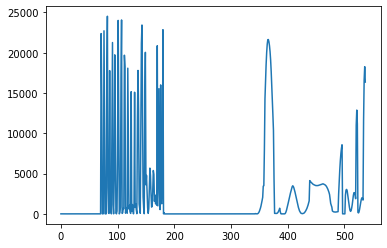

In [123]:
set1=np.loadtxt("/home/limu/Space/logs/sun_columns_s1.txt").T
set2=np.loadtxt("/home/limu/Space/logs/sun_columns_s2.txt").T
aset=np.r_[set1,set2]
pl.plot(aset[:,1])

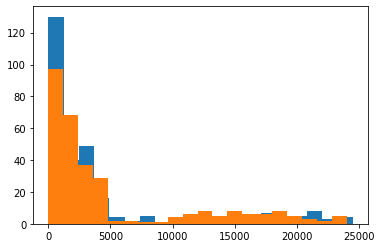

In [129]:
ssel=aset[:,0]*aset[:,1]>1000
pl.hist(aset[ssel,1],20);
pl.hist(aset[ssel,3],20);

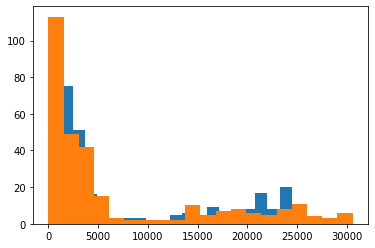

In [130]:
pl.hist(aset[ssel,0],20);
pl.hist(aset[ssel,2],20);

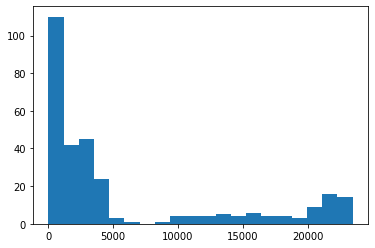

In [131]:
pl.hist(aset[ssel,4],20);

In [132]:
def get_perc(x,pval=[10,90],xmin=7000):
    xsel=x>xmin
    return np.percentile(x[xsel],pval)
[get_perc(s) for s in aset.T]

[array([12296.2, 38926.6]),
 array([ 9450. , 22220.4]),
 array([13567., 42526.]),
 array([11285.3, 21726.4]),
 array([11084. , 40996.5])]

In [133]:
sum(aset[:,4]>40000)

12